First test in notebook for correlation

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
from textblob import TextBlob

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,living_in_city,tech_background,author,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,is_image,is_empty_message,is_removed_message,sentiment_polarity,sentiment_category
0,2022-09-16 07:31:00+00:00,Wachten op dit bericht,1,1,spattered-duck,False,0,4.0,NaN,NaN,NaN,0,1,0,0.0,Neutral
1,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,1,riotous-dingo,False,0,4.0,600.0,10.0,0.166667,0,1,0,0.0,Neutral
2,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,translucent-dog,False,0,4.0,2400.0,40.0,0.666667,0,1,0,0.0,Neutral
3,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,hypnotic-rabbit,False,0,4.0,120.0,2.0,0.033333,0,1,0,0.0,Neutral
4,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,1,crystalline-uakari,False,0,4.0,2700.0,45.0,0.750000,0,1,0,0.0,Neutral


options:
- word_count and has_emoji (maybe a negative correlation)
- word_count and react_time (short messages can be responded quicker) - Straight forward
- react_time and user activity (negative correlation)
- Sentiment between users

Sentiment correlation between users

In [10]:
# Group by author
sentiment_counts = df.groupby(['author', 'sentiment_category']).size().unstack(fill_value=0)

# add total messages
sentiment_counts['Total Messages'] = sentiment_counts.sum(axis=1)

# apply order
sentiment_order = ['Positive', 'Neutral', 'Negative', 'Total Messages']

result_df = sentiment_counts.reindex(columns=sentiment_order, fill_value=0)
print(result_df)

sentiment_category  Positive  Neutral  Negative  Total Messages
author                                                         
giggly-xenops            112     1061        22            1195
goofy-chimpanzee         130     1027        25            1182
goofy-wombat              68     1219        13            1300
hilarious-human           75      745        17             837
jubilant-goshawk         190     1406        31            1627
quirky-pony              130      914        18            1062
radiant-bee              128     1100        53            1281
rubbery-butterfly         91     1028        31            1150
whimsical-gorilla         33      459         9             501


Not really useful insights from sentiment. Let's see other correlations. 

In [14]:
# Use boolean indexing to filter the DataFrame
negative_messages = df[df['sentiment_category'] == 'Negative']

# Print the author, sentiment category, and the actual message
print(negative_messages[['author', 'sentiment_category', 'message']])

                  author sentiment_category  \
10           quirky-pony           Negative   
54      goofy-chimpanzee           Negative   
141          quirky-pony           Negative   
348    rubbery-butterfly           Negative   
405      hilarious-human           Negative   
...                  ...                ...   
9856        goofy-wombat           Negative   
9953         radiant-bee           Negative   
9954        goofy-wombat           Negative   
10083   jubilant-goshawk           Negative   
10125  rubbery-butterfly           Negative   

                                                 message  
10                  Sorry man ik heb feestje van familie  
54                                         Nee man sorry  
141        Hoe the fuck krijg je brobbey tegen de vlakte  
348           Tegen half 9 - 9 uur zou ik nog wel kunnen  
405                                      Half 9 is prima  
...                                                  ...  
9856                  

Word count per user

In [18]:
word_count_stats = df.groupby('author')['word_count'].agg(
    [('Min Word Count', 'min'), 
     ('Median Word Count', 'median'), 
     ('Average Word Count', 'mean'), 
     ('Max Word Count', 'max')]
)

print(word_count_stats)

                               Min Word Count  Median Word Count  \
author                                                             
carbonated-red-eyed tree frog             1.0                5.0   
chuckling-ibis                            1.0                4.0   
eye-catching-pelican                      1.0                4.0   
frothy-barracuda                          1.0                5.0   
hypnotic-stinkbug                         1.0                3.0   
piebald-coyote                            1.0                5.0   
roguish-shark                             1.0                5.0   
silky-jellyfish                           1.0                4.0   
whimsical-human                           1.0                5.0   

                               Average Word Count  Max Word Count  
author                                                             
carbonated-red-eyed tree frog            6.688172           161.0  
chuckling-ibis                           5.4269

split into group of tech and non-technical backbround

In [29]:
tech_word_count_stats = df.groupby('tech_background')['word_count'].agg(
    [('Min Word Count', 'min'), 
     ('Median Word Count', 'median'), 
     ('Average Word Count', 'mean'), 
     ('Max Word Count', 'max')]
)

print(tech_word_count_stats)

                 Min Word Count  Median Word Count  Average Word Count  \
tech_background                                                          
0                           1.0                5.0            6.932708   
1                           1.0                4.0            5.531656   

                 Max Word Count  
tech_background                  
0                         238.0  
1                          95.0  


Calculate the correlation between two attributes. Check data types

In [41]:
print(df['tech_background'].dtype)
print(df['word_count'].dtype)

int64
float64


In [42]:
from scipy import stats

# Assuming your DataFrame is named 'df'
correlation, p_value = stats.pointbiserialr(df['tech_background'], df['word_count'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: nan
P-value: nan


Test if variance might be 0 so correlation cannot be calculated

In [33]:
print(f"Standard deviation of 'technical_background': {df['tech_background'].std()}")
print(f"Standard deviation of 'word_count': {df['word_count'].std()}")

Standard deviation of 'technical_background': 0.498668555488144
Standard deviation of 'word_count': 8.195553198526575


Check for missing values

In [43]:
print(f"Missing values in 'technical_background': {df['tech_background'].isnull().sum()}")
print(f"Missing values in 'word_count': {df['word_count'].isnull().sum()}")

Missing values in 'technical_background': 0
Missing values in 'word_count': 6


In [44]:
import pandas as pd
from scipy import stats
import numpy as np

# Assuming 'df' is your DataFrame
# First, ensure your columns have the correct data types.
# This step is crucial if the columns are of 'object' or other non-numeric types.
df['tech_background'] = df['tech_background'].astype(int)
df['word_count'] = pd.to_numeric(df['word_count'], errors='coerce')

# Drop the records (rows) where 'word_count' is NaN
df_cleaned = df.dropna(subset=['word_count'])

# Now, calculate the Point-Biserial Correlation on the cleaned DataFrame
correlation, p_value = stats.pointbiserialr(df_cleaned['tech_background'], df_cleaned['word_count'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: -0.0852
P-value: 0.0000


In [46]:
import pandas as pd
from scipy import stats
import numpy as np

# Assuming 'df' is your DataFrame
# First, ensure your columns have the correct data types.
# This step is crucial if the columns are of 'object' or other non-numeric types.
df['tech_background'] = df['tech_background'].astype(int)
df['word_count'] = pd.to_numeric(df['word_count'], errors='coerce')

# Drop the records (rows) where 'word_count' is NaN
df_cleaned = df.dropna(subset=['word_count'])

# Filter the DataFrame in a single step using boolean indexing
df_filtered = df_cleaned[
    (df_cleaned['is_image'] == 0) &
    (df_cleaned['is_empty_message'] == 0) &
    (df_cleaned['is_removed_message'] == 0)
]

# Now, calculate the Point-Biserial Correlation on the cleaned DataFrame
correlation, p_value = stats.pointbiserialr(df_filtered['tech_background'], df_filtered['word_count'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: -0.0827
P-value: 0.0000


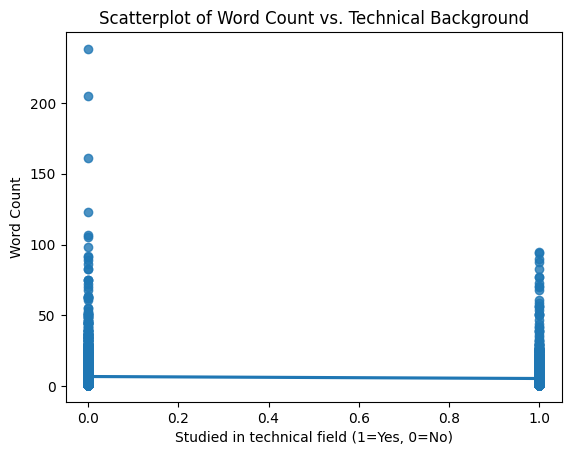

In [60]:
# Drop the records (rows) where 'word_count' is NaN
df_cleaned = df.dropna(subset=['word_count', 'tech_background'])

# Create the scatterplot with a line of best fit
sns.regplot(x='tech_background', y='word_count', data=df)

# Set the title and labels
plt.title('Scatterplot of Word Count vs. Technical Background')
plt.xlabel('Studied in technical field (1=Yes, 0=No)')
plt.ylabel('Word Count')

# Display the plot
plt.show()

# If you want to save the plot instead of displaying it
# plt.savefig('scatterplot_with_line_of_best_fit.png')

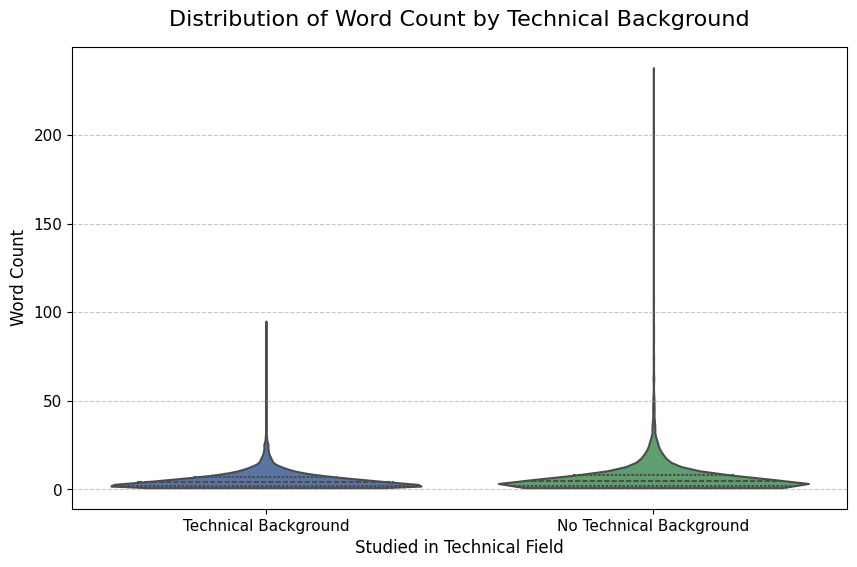

In [20]:
# Drop records (rows) where 'word_count' or 'tech_background' is NaN
df_cleaned = df.dropna(subset=['word_count', 'tech_background']).copy()

# Ensure the categorical variable is treated correctly by converting it to string/category
# This step helps with clearer labeling in the final plot.
df_cleaned['tech_label'] = df_cleaned['tech_background'].astype(int).astype(str).replace(
    {'0': 'No Technical Background', '1': 'Technical Background'}
)

# --- 3. Create the Violin Plot ---
plt.figure(figsize=(10, 6))

# Use sns.violinplot instead of sns.regplot
# The X-axis is the categorical variable ('tech_label')
# The Y-axis is the continuous variable ('word_count')
sns.violinplot(
    x='tech_label', 
    y='word_count', 
    data=df_cleaned,
    inner='quartile',  # Shows the box plot components (median and quartiles) inside the violin
    palette=['#4c72b0', '#55a868'], # Custom colors for a nice look
    linewidth=1.5,
    cut=0 # Ensures the violin shape doesn't extend beyond the data range
)

# --- 4. Set the title and labels ---
plt.title('Distribution of Word Count by Technical Background', fontsize=16, pad=15)
plt.xlabel('Studied in Technical Field', fontsize=12)
plt.ylabel('Word Count', fontsize=12)

# --- 5. Enhance Aesthetics ---
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add subtle horizontal grid lines
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Display the plot
plt.show()

# If you want to save the plot instead of displaying it
# plt.savefig('violin_plot_wordcount_vs_tech.png')


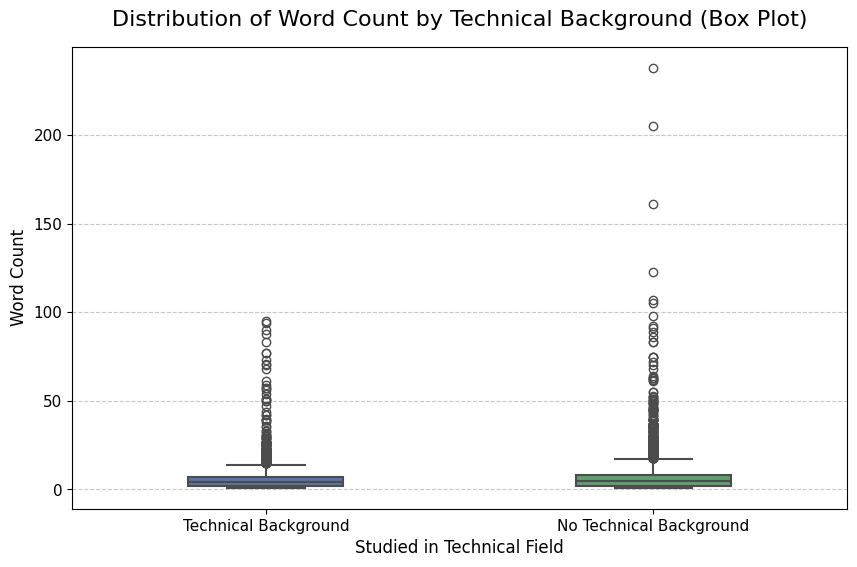

In [33]:
# Drop records (rows) where 'word_count' or 'tech_background' is NaN
df_cleaned = df.dropna(subset=['word_count', 'tech_background']).copy()

# Ensure the categorical variable is treated correctly by converting it to string/category
# This step helps with clearer labeling in the final plot.
df_cleaned['tech_label'] = df_cleaned['tech_background'].astype(int).astype(str).replace(
    {'0': 'No Technical Background', '1': 'Technical Background'}
)

# --- 3. Create the BOX PLOT ---
plt.figure(figsize=(10, 6))

# Use sns.boxplot instead of sns.violinplot
# The X-axis is the categorical variable ('tech_label')
# The Y-axis is the continuous variable ('word_count')
sns.boxplot(
    x='tech_label', 
    y='word_count', 
    data=df_cleaned,
    palette=['#4c72b0', '#55a868'], # Custom colors for a nice look
    linewidth=1.5,
    width=0.4 # Adjust box width for better visual clarity
)

# --- 4. Set the title and labels ---
plt.title('Distribution of Word Count by Technical Background (Box Plot)', fontsize=16, pad=15)
plt.xlabel('Studied in Technical Field', fontsize=12)
plt.ylabel('Word Count', fontsize=12)

# --- 5. Enhance Aesthetics ---
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add subtle horizontal grid lines
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Display the plot
plt.show()

# If you want to save the plot instead of displaying it
# plt.savefig('box_plot_wordcount_vs_tech.png')


Correlation between words count and react_time

In [51]:
print(df['react_time_min'].dtype)
print(df['word_count'].dtype)

float64
float64


In [55]:
# Count NaN values in all columns
nan_counts = df.isnull().sum()
print("NaN counts per column:")
print(nan_counts)

NaN counts per column:
timestamp             0
message               6
living_in_city        0
tech_background       0
author                0
has_emoji             0
word_count            6
react_time_sec        1
react_time_min        1
react_time_hr         1
is_image              0
is_empty_message      0
is_removed_message    0
sentiment_polarity    0
sentiment_category    0
dtype: int64


correlation between words and 

In [ ]:
from scipy.stats import pearsonr

# Drop the records (rows) where 'word_count' is NaN
df_cleaned = df.dropna(subset=['word_count', 'react_time_min'])

# Calculate correlation coefficient and p-value
correlation, p_value = pearsonr(df_cleaned['word_count'], df_cleaned['react_time_min'])

print(f"The Pearson correlation coefficient is: {correlation:.2f}")
print(f"The p-value is: {p_value:.4f}")

The Pearson correlation coefficient is: 0.14
The p-value is: 0.0000


Test in graph

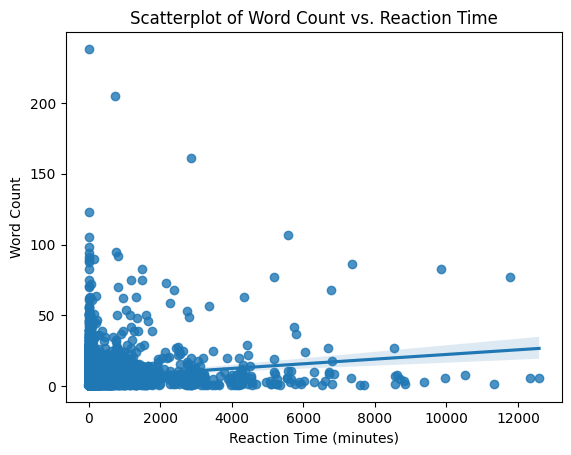

In [57]:
# Drop the records (rows) where 'word_count' is NaN
df_cleaned = df.dropna(subset=['word_count', 'react_time_min'])

# Create the scatterplot with a line of best fit
sns.regplot(x='react_time_min', y='word_count', data=df)

# Set the title and labels
plt.title('Scatterplot of Word Count vs. Reaction Time')
plt.xlabel('Reaction Time (minutes)')
plt.ylabel('Word Count')

# Display the plot
plt.show()

# If you want to save the plot instead of displaying it
# plt.savefig('scatterplot_with_line_of_best_fit.png')

correlation between has_emoji and tech_background

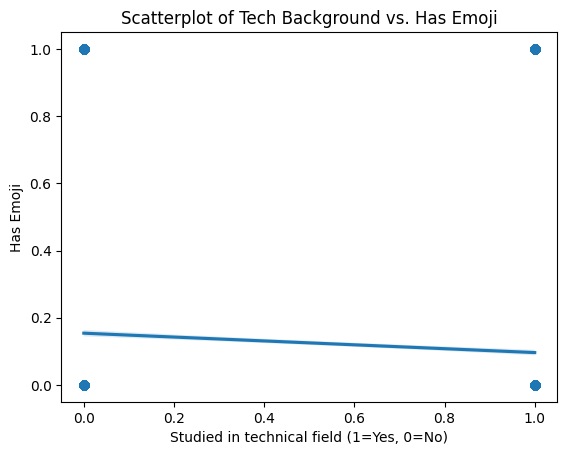

In [66]:
# Drop the records (rows) where 'word_count' is NaN
df_cleaned = df.dropna(subset=['tech_background', 'has_emoji'])

# Create the scatterplot with a line of best fit
sns.regplot(x='tech_background', y='has_emoji', data=df)

# Set the title and labels
plt.title('Scatterplot of Tech Background vs. Has Emoji')
plt.xlabel('Studied in technical field (1=Yes, 0=No)')
plt.ylabel('Has Emoji')

# Display the plot
plt.show()

# If you want to save the plot instead of displaying it
# plt.savefig('scatterplot_with_line_of_best_fit.png')

/tmp/ipykernel_11305/2551122920.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


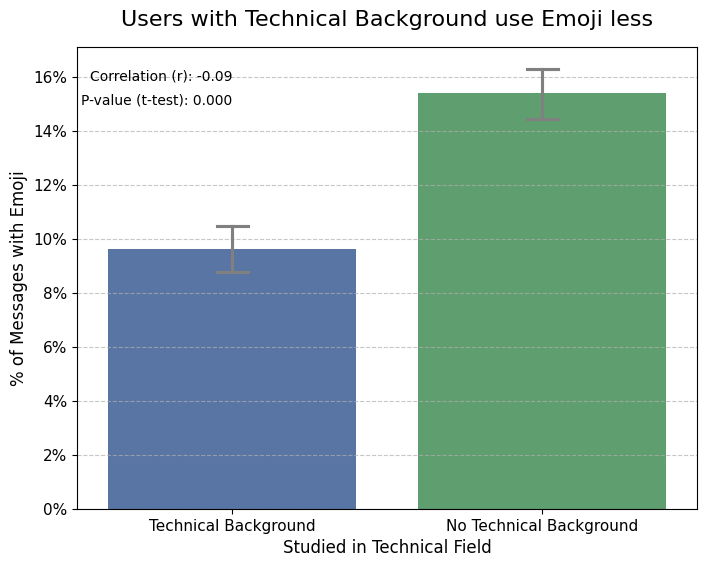


--- Contingency Table (Raw Counts) ---
has_emoji                False  True    All
tech_label                                 
No Technical Background   4603   838   5441
Technical Background      4243   452   4695
All                       8846  1290  10136
---------------------------------------------------------


In [40]:
from scipy import stats

# Ensure the categorical variable is treated correctly by converting it to string/category
df['tech_label'] = df['tech_background'].astype(int).astype(str).replace(
    {'0': 'No Technical Background', '1': 'Technical Background'}
)

# T-test for difference in means between the two groups
group_tech = df[df['tech_background'] == 1]['has_emoji']
group_nontech = df[df['tech_background'] == 0]['has_emoji']
t_stat, p_value = stats.ttest_ind(group_tech, group_nontech, equal_var=False) # Independent samples t-test

# Calculate the Point-Biserial Correlation Coefficient
# This is equivalent to Pearson's correlation when one variable is dichotomous (0/1)
correlation_coefficient, _ = stats.pearsonr(df['tech_background'], df['has_emoji'])


# --- UPGRADE 1: Use a Bar Plot to show Proportions (Recommended) ---
# A bar plot automatically calculates the mean of the continuous variable (has_emoji) 
# for each category (tech_label). Since has_emoji is 0 or 1, the mean is the proportion (%).

plt.figure(figsize=(8, 6))

ax = sns.barplot(
    x='tech_label', 
    y='has_emoji', 
    data=df,
    # The default estimator is 'mean', which here represents the proportion of users with emojis.
    palette=['#4c72b0', '#55a868'],
    errcolor='gray', 
    capsize=0.1, # Adds caps to the confidence interval bars
    linewidth=1.5
)

# --- Add Statistical Annotation to the Graph ---
# Format correlation and p-value for display
corr_text = f"Correlation (r): {correlation_coefficient:.2f}"
p_text = f"P-value (t-test): {p_value:.3f}"

# Determine text position (top right corner of the plot)
x_pos = 0.25
y_pos = 0.95
text_y_offset = 0.05

ax.text(x_pos, y_pos, corr_text, 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        horizontalalignment='right')

ax.text(x_pos, y_pos - text_y_offset, p_text, 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        horizontalalignment='right')


# --- Set the title and labels ---
plt.title('Users with Technical Background use Emoji less', fontsize=16, pad=15)
plt.xlabel('Studied in Technical Field', fontsize=12)
plt.ylabel('% of Messages with Emoji', fontsize=12)

# Format Y-axis as percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

# --- Enhance Aesthetics ---
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Display the plot
plt.show()

# --- UPGRADE 2: Display the Contingency Table (Actual Counts) ---
print("\n--- Contingency Table (Raw Counts) ---")
contingency_table = pd.crosstab(
    df['tech_label'], 
    df['has_emoji'].replace({0: 'No Emoji', 1: 'Has Emoji'}), # Use labels for clarity
    margins=True # Adds the row/column totals
)
print(contingency_table)
print("---------------------------------------------------------")

KeyError: 'No Technical Background'

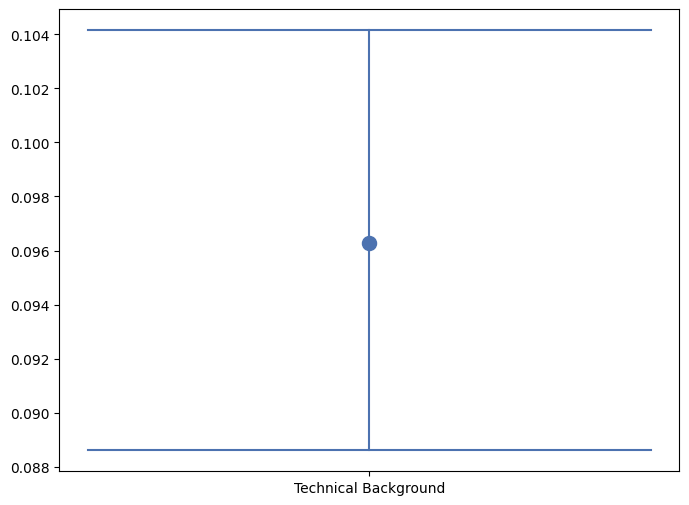

In [10]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the categorical variable is treated correctly by converting it to string/category
df['tech_label'] = df['tech_background'].astype(int).astype(str).replace(
    {'0': 'No Technical Background', '1': 'Technical Background'}
)

# T-test for difference in means between the two groups
group_tech = df[df['tech_background'] == 1]['has_emoji']
group_nontech = df[df['tech_background'] == 0]['has_emoji']
t_stat, p_value = stats.ttest_ind(group_tech, group_nontech, equal_var=False) # Independent samples t-test

# Calculate the Point-Biserial Correlation Coefficient
correlation_coefficient, _ = stats.pearsonr(df['tech_background'], df['has_emoji'])


# --- UPGRADED PLOT: Use a Point Plot (Dots) to show Proportions and CIs ---

plt.figure(figsize=(8, 6))

# Using seaborn.pointplot instead of barplot. 
# It plots the mean (dot) and the 95% confidence interval (vertical line).
ax = sns.pointplot(
    x='tech_label', 
    y='has_emoji', 
    data=df,
    estimator=np.mean, # Explicitly use mean (which is the proportion here)
    marker='o',        # Use a circle marker for the mean
    markersize=10,     # Size of the dot
    linestyles=[''],   # IMPORTANT: Remove the line connecting the points
    palette=['#4c72b0', '#55a868'],
    capsize=0.15,      # Adds caps to the confidence interval bars
    linewidth=1.5      # Thickness of the CI line
)

# --- Add Statistical Annotation to the Graph ---
# Format correlation and p-value for display
corr_text = f"Correlation (r): {correlation_coefficient:.2f}"
p_text = f"P-value (t-test): {p_value:.3f}"

# Determine text position (top right corner of the plot)
# Using a fixed coordinate system (ax.transAxes)
x_pos = 0.95
y_pos = 0.95
text_y_offset = 0.05

ax.text(x_pos, y_pos, corr_text, 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

ax.text(x_pos, y_pos - text_y_offset, p_text, 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))


# --- Set the title and labels ---
plt.title('Comparison of Emoji Usage: Point Plot with CIs', fontsize=16, pad=15)
plt.xlabel('Studied in Technical Field', fontsize=12)
plt.ylabel('% of Messages with Emoji', fontsize=12)

# Format Y-axis as percentage
current_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in current_ticks])
plt.ylim(0, max(current_ticks) * 1.05) # Ensure CIs fit nicely

# --- Enhance Aesthetics ---
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine(left=True, bottom=True) # Remove top and right spines

# Display the plot
plt.show()

# --- Display the Contingency Table (Actual Counts) ---
print("\n--- Contingency Table (Raw Counts) ---")
contingency_table = pd.crosstab(
    df['tech_label'], 
    df['has_emoji'].replace({0: 'No Emoji', 1: 'Has Emoji'}), # Use labels for clarity
    margins=True # Adds the row/column totals
)
print(contingency_table)
print("---------------------------------------------------------")


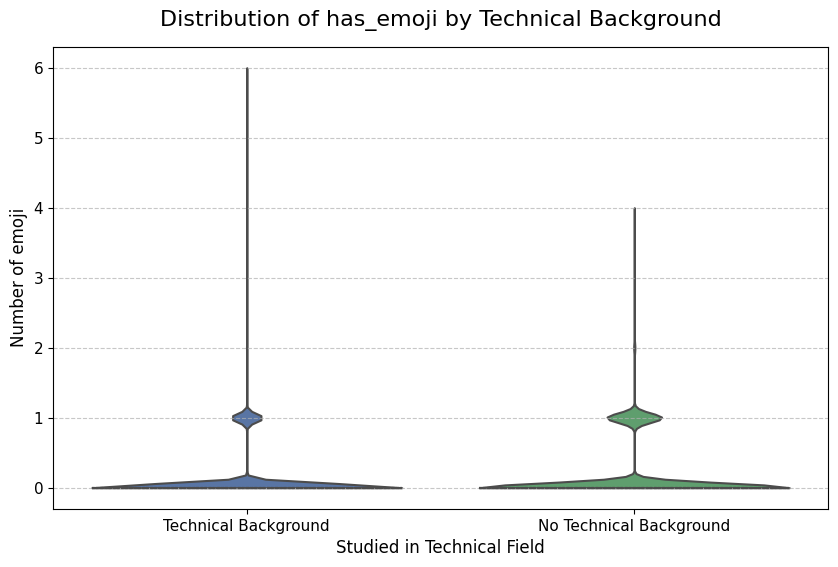

In [27]:
# Drop records (rows) where 'emoji_count' or 'tech_background' is NaN
df_cleaned = df.dropna(subset=['emoji_count', 'tech_background']).copy()

# Ensure the categorical variable is treated correctly by converting it to string/category
# This step helps with clearer labeling in the final plot.
df_cleaned['tech_label'] = df_cleaned['tech_background'].astype(int).astype(str).replace(
    {'0': 'No Technical Background', '1': 'Technical Background'}
)

# --- 3. Create the Violin Plot ---
plt.figure(figsize=(10, 6))

# Use sns.violinplot instead of sns.regplot
# The X-axis is the categorical variable ('tech_label')
# The Y-axis is the continuous variable ('word_count')
sns.violinplot(
    x='tech_label', 
    y='emoji_count', 
    data=df_cleaned,
    inner='quartile',  # Shows the box plot components (median and quartiles) inside the violin
    palette=['#4c72b0', '#55a868'], # Custom colors for a nice look
    linewidth=1.5,
    cut=0 # Ensures the violin shape doesn't extend beyond the data range
)

# --- 4. Set the title and labels ---
plt.title('Distribution of has_emoji by Technical Background', fontsize=16, pad=15)
plt.xlabel('Studied in Technical Field', fontsize=12)
plt.ylabel('Number of emoji', fontsize=12)

# --- 5. Enhance Aesthetics ---
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add subtle horizontal grid lines
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Display the plot
plt.show()

# If you want to save the plot instead of displaying it
# plt.savefig('violin_plot_wordcount_vs_tech.png')


Correlation between all metrics

In [28]:
import numpy as np

df_numeric = df.drop(columns=['author', 'message', 'sentiment_category', 'timestamp'])

correlation_matrix = df_numeric.corr()
print(correlation_matrix)

                    living_in_city  tech_background  has_emoji  emoji_count  \
living_in_city            1.000000        -0.171798   0.052196     0.052213   
tech_background          -0.171798         1.000000  -0.086395    -0.082328   
has_emoji                 0.052196        -0.086395   1.000000     0.972651   
emoji_count               0.052213        -0.082328   0.972651     1.000000   
word_count                0.048339        -0.085247   0.050905     0.060039   
react_time_sec           -0.022929         0.008767   0.002941     0.004305   
react_time_min           -0.022929         0.008767   0.002941     0.004305   
react_time_hr            -0.022929         0.008767   0.002941     0.004305   
is_image                  0.033425         0.045495  -0.102324    -0.099526   
is_empty_message         -0.002341        -0.007764  -0.011384    -0.011073   
is_removed_message        0.008210        -0.009227  -0.003793    -0.003689   
sentiment_polarity        0.010760        -0.001838 

Check for acceptance and rejects in a message

In [17]:
import pandas as pd

# Assume your data is in a DataFrame called 'df'
# with a column named 'text'

# 1. Define the acceptance keywords
acceptance_keywords = [
    "prima",
    "ik ben er wel",
    "ik kan wel",
    "ik kan ook wel",
    "kom er aan",
    "vind ik goed",
    "ik ga wel mee",
    "ik wil wel mee",
    "ik kan daarna nog wel",
    "kom wel ff langs",
    "ik ook wel",
    "goed idee",
    "ik kan vnv wel",
    "ik kan vanavond wel",
    "ik kan zaterdagavond wel",
    "ik kan zaterdag wel",
    "ik kan vrijdagavond wel",
    "ik kan vrijdag wel"
]

# 2. Create the function to check for acceptance
def check_for_acceptance(text):
    text_lower = str(text).lower()  # Handle potential non-string values
    for keyword in acceptance_keywords:
        if keyword in text_lower:
            return 1
    return 0

# 3. Apply the function to create the new column
df['registers_acceptance'] = df['message'].apply(check_for_acceptance)

# 4. Define rejection keywords

reject_keywords = [
    "ik kan niet",
    "helaas",
    "helaas niet"
    "niet",
    "gaat niet",
    "geen tijd",
    "ik ben er niet",
    "ik kan er niet",
    "ik heb al iets",
    "ik heb andere plannen",
    "ik ben bezet",
    "ik ben er dit weekend niet",
    "ik kan dit weekend niet",
    "ik blijf dit weekend in amsterdam",
    "ik kan vnv niet",
    "ik kan vanavond niet",
    "ik kan zaterdagavond niet",
    "ik kan zaterdag niet",
    "ik kan vrijdagavond niet",
    "ik kan vrijdag niet"
]

# 5. Function

def check_for_decline(text):
    text_lower = str(text).lower()  # Handle potential non-string values
    for keyword in reject_keywords:
        if keyword in text_lower:
            return 1
    return 0

# 3. Apply the function to create the new column
df['registers_decline'] = df['message'].apply(check_for_decline)

print(df[['message', 'registers_acceptance', 'registers_decline']])

                                                 message  \
0                                 Wachten op dit bericht   
1                                 Wachten op dit bericht   
2                                 Wachten op dit bericht   
3                                 Wachten op dit bericht   
4                                 Wachten op dit bericht   
...                                                  ...   
10131                                 <Media weggelaten>   
10132                             Dat word zweten Robert   
10133                         Alsof ik daar voor wegloop   
10134                          Dit bericht is verwijderd   
10135  Zo lang weda zorgt voor de hydratatie dan komt...   

       registers_acceptance  registers_decline  
0                         0                  0  
1                         0                  0  
2                         0                  0  
3                         0                  0  
4                         0       

In [18]:
print(df.head(200).to_string())

                    timestamp                                                                                                                                                                                                                                                                          message  living_in_city  tech_background                author  has_emoji  word_count  react_time_sec  react_time_min  react_time_hr  is_image  is_empty_message  is_removed_message  sentiment_polarity sentiment_category  registers_acceptance  registers_decline
0   2022-09-16 07:31:00+00:00                                                                                                                                                                                                                                                           Wachten op dit bericht               1                1        spattered-duck      False         4.0             NaN             NaN            NaN         0       

Correlation with new metrics

In [19]:
import numpy as np

df_numeric = df.drop(columns=['author', 'message', 'sentiment_category', 'timestamp'])

correlation_matrix = df_numeric.corr()
print(correlation_matrix)

                      living_in_city  tech_background  has_emoji  word_count  \
living_in_city              1.000000        -0.171798   0.052196    0.048339   
tech_background            -0.171798         1.000000  -0.086395   -0.085247   
has_emoji                   0.052196        -0.086395   1.000000    0.050905   
word_count                  0.048339        -0.085247   0.050905    1.000000   
react_time_sec             -0.022929         0.008767   0.002941    0.138833   
react_time_min             -0.022929         0.008767   0.002941    0.138833   
react_time_hr              -0.022929         0.008767   0.002941    0.138833   
is_image                    0.033425         0.045495  -0.102324   -0.139102   
is_empty_message           -0.002341        -0.007764  -0.011384   -0.008311   
is_removed_message          0.008210        -0.009227  -0.003793   -0.001557   
sentiment_polarity          0.010760        -0.001838  -0.026666   -0.001686   
registers_acceptance       -0.058264    